# Assignment 3 - Building a Custom Visualization

---

In this assignment you must choose one of the options presented below and submit a visual as well as your source code for peer grading. The details of how you solve the assignment are up to you, although your assignment must use matplotlib so that your peers can evaluate your work. The options differ in challenge level, but there are no grades associated with the challenge level you chose. However, your peers will be asked to ensure you at least met a minimum quality for a given technique in order to pass. Implement the technique fully (or exceed it!) and you should be able to earn full grades for the assignment.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).

<br>
<img src="readonly/Assignment3Fig1.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Figure 1 from (Ferreira et al, 2014).</h4>

<br>

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.


<br>
<img src="readonly/Assignment3Fig2c.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  Figure 2c from (Ferreira et al. 2014). Note that the colorbar legend at the bottom as well as the arrows are not required in the assignment descriptions below.</h4>

<br>
<br>

**Easiest option:** Implement the bar coloring as described above - a color scale with only three colors, (e.g. blue, white, and red). Assume the user provides the y axis value of interest as a parameter or variable.


**Harder option:** Implement the bar coloring as described in the paper, where the color of the bar is actually based on the amount of data covered (e.g. a gradient ranging from dark blue for the distribution being certainly below this y-axis, to white if the value is certainly contained, to dark red if the value is certainly not contained as the distribution is above the axis).

**Even Harder option:** Add interactivity to the above, which allows the user to click on the y axis to set the value of interest. The bar colors should change with respect to what value the user has selected.

**Hardest option:** Allow the user to interactively set a range of y values they are interested in, and recolor based on this (e.g. a y-axis band, see the paper for more details).

---

*Note: The data given for this assignment is not the same as the data used in the article and as a result the visualizations may look a little different.*

In [1]:
# Use the following data for this assignment:

import pandas as pd
import numpy as np
import scipy.stats as st

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(33500,150000,3650), 
                   np.random.normal(41000,90000,3650), 
                   np.random.normal(41000,120000,3650), 
                   np.random.normal(48000,55000,3650)], 
                  index=[1992,1993,1994,1995])
#print(df)
print(df.T.describe())

                1992           1993           1994           1995
count    3650.000000    3650.000000    3650.000000    3650.000000
mean    34484.080607   39975.673587   37565.689950   47798.504333
std    150473.176164   88558.520583  120317.078777   54828.074297
min   -528303.381600 -287127.421315 -382709.382654 -138894.685422
25%    -67555.298773  -21665.471992  -45516.912051   11680.007981
50%     31756.198287   41001.778992   39197.241173   49103.396625
75%    135081.379021   99766.920131  121367.183244   84271.976610
max    622629.206119  358327.854561  423792.855746  262363.983464


In [2]:
#this is right method for interval

#df['i_min'], df['i_max']=st.t.interval(0.95, len(df.count(axis=1))-1, loc=df.mean(axis=1), scale=df.sem(axis=1))
#df['yerr']=(df['i_max'].abs() - df['i_min'].abs() )

df['mean']=df.mean(axis=1)
df['std']=df.std(axis=1)

#this is approximate method for interval
df['sem']=df.sem(axis=1)
df['i_min']=df['mean']-df['sem']*4
df['i_max']=df['mean']+df['sem']*4

df['yerr']=df['sem']*4 
print(df[['mean', 'i_min', 'i_max', 'yerr', 'std', 'sem']])

              mean         i_min         i_max         yerr            std  \
1992  34484.080607  24526.128257  44442.032957  9957.952350  150452.561989   
1993  39975.673587  34115.319328  45836.027846  5860.354259   88546.388448   
1994  37565.689950  29603.527572  45527.852328  7962.162378  120300.595857   
1995  47798.504333  44170.401478  51426.607188  3628.102855   54820.563088   

              sem  
1992  2489.488088  
1993  1465.088565  
1994  1990.540595  
1995   907.025714  


<IPython.core.display.Javascript object>


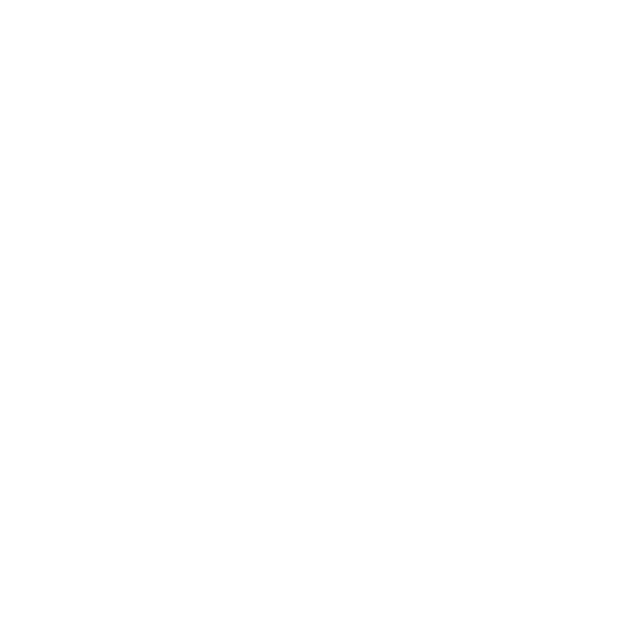

7

In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

cl_max_color='red'
cl_min_color='blue'
cl_neitral_color='grey'

class Cursor(object):
    _df=None
    _bl=None
    def __init__(self, ax, data_F, bars):
        self._df=data_F
        self._bl=bars
        self.ax = ax
        self.lx = ax.axhline(color='b')

    def mouse_move(self, event):
        if not event.inaxes:
            return
        x, y = event.xdata, event.ydata
        self.lx.set_ydata(y)
        for index, row in self._df.iterrows():
            if row['i_max']<y:
                self._bl[self._df.index.get_loc(index)].set_color(cl_min_color)
                continue
            if row['i_min']>y:
                self._bl[self._df.index.get_loc(index)].set_color(cl_max_color)
                continue
            
            self._bl[self._df.index.get_loc(index)].set_color(cl_neitral_color)
        plt.draw()

        
def plot_base(fix_x, fig_y, fig_title, c_alpha=0.5):
    ax=df['mean'].plot.bar(yerr=df['yerr'], 
        title =fig_title, figsize=(fix_x, fig_y), 
        legend=False, fontsize=10, alpha=c_alpha, width=0.95, 
        rot=0, position=0, style='-', color=cl_neitral_color)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    majors = [0.5,1.5,2.5, 3.5]
    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))

    plt.tight_layout()
    
    return (ax, ax.get_children()[1:5])

ax, barlist=plot_base(5, 5, "Easiest option")

cursor = Cursor(ax, df, barlist)
plt.connect('motion_notify_event', cursor.mouse_move)

<IPython.core.display.Javascript object>


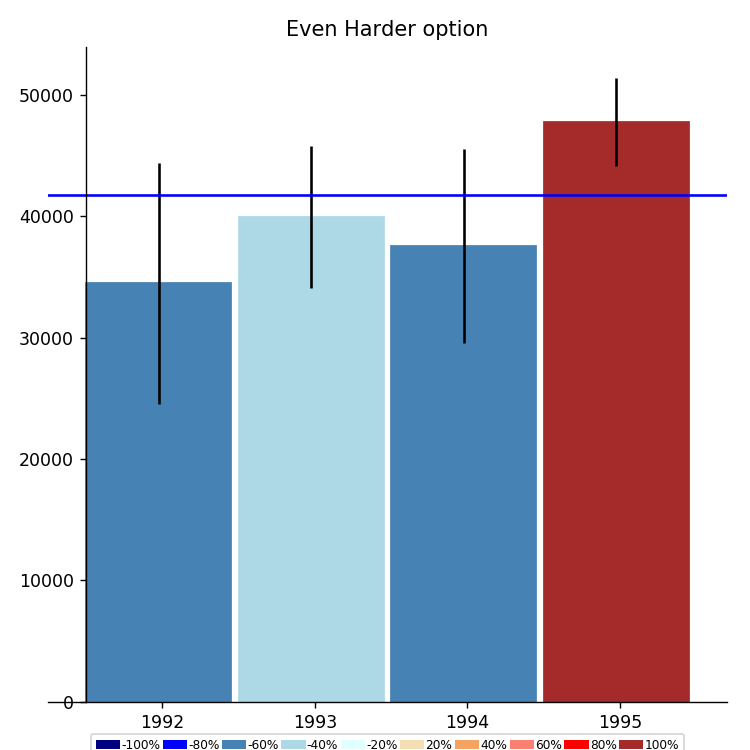

7

In [4]:
#import matplotlib.lines as mlines
%matplotlib notebook
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

from collections import OrderedDict


dct=OrderedDict( [('navy','-100%'), ('blue','-80%'), ('steelblue','-60%'), ('lightblue','-40%'), 
                ('lightcyan','-20%'), ('wheat','20%'), ('sandybrown','40%'), 
                ('salmon','60%'), ('red','80%'), ('brown','100%')] )

com_alpha=0.7

class CursorHard(Cursor):
    #_colors=list(dct.keys())
    _colors=list(reversed(dct.keys()))
    _num_bins=8
    def _get_color(self, d_series, val):
        s=d_series[['i_min', 'i_max']]
        s['val']=val
        s=pd.cut(s, bins=self._num_bins, labels=list(range(self._num_bins)), include_lowest=False, right=True)
        return self._colors[s['val']+1]

    def mouse_move(self, event):
        if not event.inaxes:
            return
        x, y = event.xdata, event.ydata
        self.lx.set_ydata(y)
        for index, row in self._df.iterrows():
            if row['i_max']<y:
                self._bl[self._df.index.get_loc(index)].set_color(self._colors[-1])
                continue
            if row['i_min']>y:
                self._bl[self._df.index.get_loc(index)].set_color(self._colors[0])
                continue
            
            self._bl[self._df.index.get_loc(index)].set_color(self._get_color(row, y))
        plt.draw()

ax1, barlist1=plot_base(6, 6, 'Even Harder option', c_alpha=1) 

bars_leg=[]

for k, v in dct.items():
    p=Rectangle((0, 0), 1, 1, fc=k, label=v)
    bars_leg.append(p)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.04), 
           handles=bars_leg, ncol=len(bars_leg), columnspacing=0.2, handletextpad=0.1, fontsize=7)

plt.tight_layout()
plt.show()

hcursor = CursorHard(ax1, df, barlist1)
plt.connect('motion_notify_event', hcursor.mouse_move)
